Proyecto Final Grupo 15

## Obtención de los Datos

En esta sección, realizamos los imports necesarios y preparamos en las carpetas correspondientes el dataset que utilizaremos.

In [ ]:
from torch.utils.data import ConcatDataset, Subset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from fastai.vision.all import *
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive
import torch.optim as optim
from PIL import Image
import torch.nn as nn
import numpy as np
import shutil
import torch
import os

In [ ]:
drive.mount('/content/drive', force_remount=True)

ruta_vc_final = '/content/drive/MyDrive/VC_FINAL/Files'

# Comprueba si la ruta existe y lista las subcarpetas
if os.path.exists(ruta_vc_final):
    print(f"Listando subcarpetas dentro de: {ruta_vc_final}")
    subcarpetas = next(os.walk(ruta_vc_final))[1]  # Esto listará solo directorios, no archivos individuales
    for subcarpeta in subcarpetas:
        print(subcarpeta)
else:
    print("Error listando las subcarpetas")


Mounted at /content/drive
Listando subcarpetas dentro de: /content/drive/MyDrive/VC_FINAL/Files
Japonicus_koreicus
Aedes_japonicus
Aedes_koreicus
Aedes_albopictus
Aedes_aegypti
Not_sure
Culex
Culex_segmentadas
Aedes_albopictus_segmentadas
Aedes_japonicus_segmentadas
Aedes_koreicus_segmentadas
Aedes_albopictus_resized
Aedes_japonicus_resized
Culex_resized
Aedes_aegypti_resized
Japonicus_koreicus_segmentadas
Aedes_aegypti_segmentadas
Japonicus+koreicus
Japonicus+koreicus_resized
Japonicus+koreicus_segmentadas
Aedes_aegypti_segmentadas_resized
Japonicus+koreicus_segmentadas_resized
Aedes_albopictus_segmentadas_resized
Culex_segmentadas_resized
imagenes_ejemplos


In [ ]:
carpetas_interes = ['Japonicus+koreicus', 'Aedes_albopictus', 'Aedes_aegypti', 'Culex']
conteo_archivos = {}

# Ruta de la nueva carpeta para guardar las imágenes
ruta_nueva_carpeta = '/content/drive/MyDrive/VC_FINAL/Im_Originales'
os.makedirs(ruta_nueva_carpeta, exist_ok=True)  # Crea la carpeta si no existe


# Lista solo las subcarpetas de interés
subcarpetas_interes = []

if os.path.exists(ruta_vc_final):
    print(f"Buscando subcarpetas originales dentro de: {ruta_vc_final} \n")
    subcarpetas = next(os.walk(ruta_vc_final))[1]  # Esto listará solo directorios
    for subcarpeta in subcarpetas:
        if subcarpeta in carpetas_interes:
            ruta_subcarpeta = os.path.join(ruta_vc_final, subcarpeta)
            archivos = os.listdir(ruta_subcarpeta)
            conteo_archivos[subcarpeta] = len(archivos)
            print(f"{subcarpeta}:  {len(archivos)} archivos")

            # Establece la ruta de destino para la subcarpeta
            destino_subcarpeta = os.path.join(ruta_nueva_carpeta, subcarpeta)

            # Verifica si la subcarpeta ya existe en el destino
            if not os.path.exists(destino_subcarpeta):
                # Copia la subcarpeta entera si no existe
                shutil.copytree(ruta_subcarpeta, destino_subcarpeta)
                print(f"Copiada subcarpeta: {subcarpeta}")
            else:
                # Si la subcarpeta ya existe, copia solo los archivos que faltan
                for archivo in archivos:
                    ruta_archivo_origen = os.path.join(ruta_subcarpeta, archivo)
                    ruta_archivo_destino = os.path.join(destino_subcarpeta, archivo)
                    if not os.path.exists(ruta_archivo_destino):
                        shutil.copy(ruta_archivo_origen, ruta_archivo_destino)
                print(f"Actualizada subcarpeta: {subcarpeta}")
else:
    print("La ruta no existe")

total_imagenes = sum(conteo_archivos.values())
print("\nTotal de imágenes en el dataset:", sum(conteo_archivos.values()))
print("Proceso de copia completado.")


Buscando subcarpetas originales dentro de: /content/drive/MyDrive/VC_FINAL/Files 

Aedes_albopictus:  1025 archivos
Actualizada subcarpeta: Aedes_albopictus
Aedes_aegypti:  75 archivos
Actualizada subcarpeta: Aedes_aegypti
Culex:  1016 archivos
Actualizada subcarpeta: Culex
Japonicus+koreicus:  210 archivos
Actualizada subcarpeta: Japonicus+koreicus

Total de imágenes en el dataset: 2326
Proceso de copia completado.


## Creación DataBlock

En estas celdas, verificamos la integridad de los ejemplos (por si alguna imagen ha quedado corrupta en el proceso de copia) y definimos los cargadores de datos. Añadimos Data augmentation y normalización para optimizar el proceso de entrenamiento, ambos procesos respaldados ampliamente por la literatura actual de la materia. Además, para tratar de disminuir los efectos del desbalanceo de clases, aplicamos cuando es posible pesos discriminativos para las distintas etiquetas. De este modo, intentamos evitar que los modelos aprendan a etiquetar simplemente con las clases mayoritarias, lo que podría ofrecer resultados aparentemente positivos cuando la realidad es distinta.

In [ ]:
def verificar_y_limpiar_imagenes(ruta_nueva_carpeta):
    for root, _, archivos in os.walk(ruta_nueva_carpeta):
        for archivo in archivos:
            if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
                ruta_completa = os.path.join(root, archivo)
                try:
                    with Image.open(ruta_completa) as img:
                        img.verify()  # Verificar si está corrupta
                        img = Image.open(ruta_completa)  # Volver a abrir la imagen
                        img.load()  # Intentar cargar la imagen completamente
                except Exception as e:  # Capturar cualquier tipo de excepción
                    print('Imagen corrupta o truncada:', ruta_completa)
                    os.remove(ruta_completa)  # Eliminar la imagen corrupta o truncada

verificar_y_limpiar_imagenes("/content/drive/MyDrive/VC_FINAL/Im_Originales/")


In [ ]:
def stratified_splitter(items, train_size=0.85, random_state=42):
    # Obtener las etiquetas de los elementos
    labels = [parent_label(item) for item in items]

    # Dividir los datos de manera estratificada
    items_train, items_val = train_test_split(items, train_size=train_size, random_state=random_state, stratify=labels)

    # Crear listas de índices para entrenamiento y validación
    train_idx = [i for i, item in enumerate(items) if item in items_train]
    val_idx = [i for i, item in enumerate(items) if item in items_val]

    return (train_idx, val_idx)

# Definir el datablock
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=stratified_splitter, # RandomSplitter(valid_pct=0.15, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),  # Redimensionar todas las imágenes a 224x224
    batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]#data augmentation y normalización
)

# Cargar los datos en un DataLoader
dls = datablock.dataloaders("/content/drive/MyDrive/VC_FINAL/Im_Originales/", bs=64)

# 85% entrenamiento, 15% test

test_dl = dls.valid

# Imprimir los conteos de nuevo
print("Número de elementos en el conjunto de entrenamiento:", len(dls.train.dataset))
print("Número de elementos en el conjunto de prueba:", len(test_dl.dataset))

Número de elementos en el conjunto de entrenamiento: 1993
Número de elementos en el conjunto de prueba: 352


In [ ]:
total_muestras = sum(conteo_archivos.values())
pesos_clases = {clase: total_muestras / conteo for clase, conteo in conteo_archivos.items() if clase in carpetas_interes}

print("Pesos de las clases: ", pesos_clases)

# Convertir los pesos en un tensor
weights_tensor = torch.tensor(list(pesos_clases.values()), dtype=torch.float)

Pesos de las clases:  {'Aedes_albopictus': 2.2692682926829266, 'Aedes_aegypti': 31.013333333333332, 'Culex': 2.2893700787401574, 'Japonicus+koreicus': 11.076190476190476}


In [ ]:
# Function to display evaluation metrics

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

## CNN

Presentamos una red convolucional diseñada desde cero como primera aproximación al problema. La entrenamos con el método fit one cycle.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):  # Ajusta el número de clases según sea necesario
        super(CNN, self).__init__()
        # Bloque 1: Conv -> ReLU -> MaxPooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Bloque 2: Conv -> ReLU -> MaxPooling
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Bloque 3: Conv -> ReLU -> MaxPooling
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Capas totalmente conectadas: FC -> ReLU -> FC
        self.fc1 = nn.Linear(in_features=128*28*28, out_features=512)  # Ajusta según el tamaño de tus imágenes
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Aplanamiento de las características
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
red_CNN = CNN(num_classes=4)  # Ajusta el número de clases según tu problema

# Crear el Learner con red_CNN
learn_CNN = Learner(dls, red_CNN, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Mostrar un resumen del modelo
print(learn_CNN.summary())

CNN (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 224 x 224 
Conv2d                                    896        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 112 x 112 
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 112 x 112 
Conv2d                                    18496      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 56 x 5

In [ ]:
# Entrenar el modelo
learn_CNN.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.109422,1.047596,0.522727,08:01
1,1.078771,1.023991,0.539773,04:42
2,1.042537,1.017404,0.599432,04:42
3,1.000630,0.903215,0.622159,04:47
4,0.955832,0.866537,0.684659,04:53
5,0.923286,0.876938,0.659091,04:51
6,0.888675,0.862187,0.656250,04:50
7,0.858860,0.803847,0.681818,04:48
8,0.833875,0.804394,0.701705,04:48
9,0.806578,0.805153,0.698864,04:48


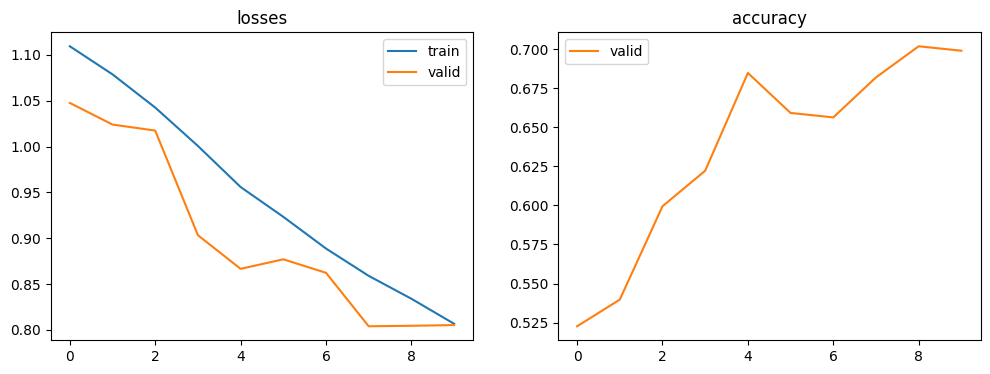

In [ ]:
learn_CNN.recorder.plot_metrics()

Las gráficas de mostradas nos enseñan que el entrenamiento ha ido bien, ya que la función de pérdida ha ido disminuyendo en ambos conjuntos mientras que la accuracy ha aumentado en el conunto de validación. Por otro lado, vemos que los datos del conjunto de validación son muy fluctuantes. Esto es algo que se va a repetir durante todos los experimentos. Nuestra hipótesis es que, al contar con un dataset pequeño, cada vez que los modelos pasan de etiquetar mal un ejemplo a etiquetarlo bien o viceversa, la influencia de estos cambios sobre la puntuación final es grande, por lo que las fluctuaciones son grandes a pesar de que la tendencia sea la esperable.

Ahora, utilizamos una red similar a la primera pero más simple. Debido a que no tenemos demasiados ejemplos, es interesante ver la diferencia entre una red más grande y potente pero con más probabilidades de sobre entrenar con otra más pequeña y menos potente pero que, a priori, no sobre entrenará tanto.

In [ ]:
# Definición de una red neuronal convolucional simple
class CNN_2(nn.Module):
    def __init__(self, num_classes):
        super(CNN_2, self).__init__()
        # Usamos una arquitectura simple con dos capas convolucionales y una capa lineal
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, num_classes)  # Ajustar según el tamaño de entrada

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Capa 1
        x = self.pool(self.relu(self.conv1(x)))
        # Capa 2
        x = self.pool(self.relu(self.conv2(x)))
        # Aplanar los datos para la capa lineal
        x = x.view(-1, 32 * 56 * 56)
        # Capa lineal
        x = self.fc1(x)
        return x

In [ ]:
# Crear una instancia de la red
num_classes = 4
redCNN_2 = CNN_2(num_classes)

# Criterio de pérdida
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Crear un Learner
learner_CNN_2 = Learner(dls, redCNN_2, loss_func=criterion, opt_func=Adam, metrics=accuracy)

print(learner_CNN_2.summary())

CNN_2 (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 16 x 224 x 224 
Conv2d                                    448        True      
____________________________________________________________________________
                     64 x 32 x 112 x 112 
Conv2d                                    4640       True      
____________________________________________________________________________
                     64 x 4              
Linear                                    401412     True      
____________________________________________________________________________
                     64 x 32 x 56 x 56   
MaxPool2d                                                      
ReLU                                                           
____________________________________________________________________________

Total params: 406,500
Total trainable params: 406,500
Total non-trainable params: 0

Optimizer used

In [ ]:
# Entrenar el modelo
learner_CNN_2.fit_one_cycle(9)

epoch,train_loss,valid_loss,accuracy,time
0,0.463458,1.759790,0.443182,05:05
1,0.472138,1.823103,0.443182,05:09
2,0.467781,1.446267,0.446023,04:49
3,0.460295,1.554808,0.443182,04:48
4,0.451472,1.471424,0.457386,04:48
5,0.442666,1.482594,0.448864,04:47
6,0.446701,1.210950,0.488636,04:48
7,0.440453,1.354719,0.460227,04:46
8,0.427372,1.359497,0.454545,05:01


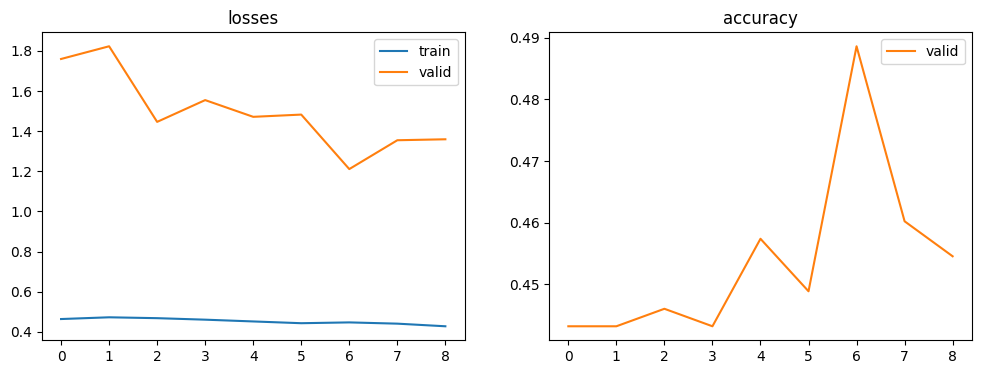

In [ ]:
learner_CNN_2.recorder.plot_metrics()

Observando las gráficas, vemos que el modelo no ha podido reducir la pérdida ni mejorar su capacidad de clasificación. Concluímos que, sencillamente, no es lo suficientemente potente como para resolver el problema.

Por el momento, nos quedamos con la primera aproximación, que obtiene una accuracy de casi el 70% en validación.

##LeNet

Ahora, utilizamos el modelo preentrenado LeNet para realizar un finetunning para nuestro problema. Utilizamos la función de dicho nombre de fastai para que el entrenamiento se haga con learning rates discriminativos según la profundidad del modelo.

In [ ]:
def calcular_tamano_entrada(alto, ancho):
    # Simula la propagación hacia adelante para calcular la forma de la salida
    modelo_temporal = nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5, padding=2),
        nn.AvgPool2d(2, 2),
        nn.Conv2d(6, 16, kernel_size=5),
        nn.AvgPool2d(2, 2)
    )
    # Crea un tensor temporal con tamaño (1, 3, alto, ancho)
    entrada_temporal = torch.rand(1, 3, alto, ancho)
    salida_temporal = modelo_temporal(entrada_temporal)
    return int(np.prod(salida_temporal.size()))

In [ ]:
def RedLeNet(num_clases):
    return nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5, padding=2),  # 3 canales de entrada, 6 de salida, kernel de 5x5
        nn.ReLU(),
        nn.AvgPool2d(2, 2),  # Pooling con kernel de 2x2
        nn.Conv2d(6, 16, kernel_size=5),
        nn.ReLU(),
        nn.AvgPool2d(2, 2),  # Pooling con kernel de 2x2
        nn.Flatten(),  # Aplanar los resultados para la capa lineal
        nn.Linear(calcular_tamano_entrada(224, 224), 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, num_clases)
    )

In [ ]:
# Crear el modelo LeNet
num_clases = len(dls.vocab)
modelo = RedLeNet(num_clases)

# Crear el Learner
learn_LeNet = Learner(dls, modelo, loss_func=F.cross_entropy, metrics=accuracy)

# Mostrar un resumen del modelo
print(learn_LeNet.summary())

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 224 x 224  
Conv2d                                    456        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 6 x 112 x 112  
AvgPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 108 x 108 
Conv2d                                    2416       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 54 x 54   
AvgPool2d                                                      
____________________________________________________________________________
                     64 x 46656

In [ ]:
# Entrenar el modelo
learn_LeNet.fit_one_cycle(9)

epoch,train_loss,valid_loss,accuracy,time
0,1.155766,1.069324,0.528409,04:38
1,1.088545,1.037265,0.531250,04:46
2,1.061445,1.019751,0.525568,04:37
3,1.022538,0.967285,0.568182,04:36
4,1.007635,0.974075,0.539773,05:15
5,0.989851,0.930924,0.579545,05:26
6,0.970869,0.930690,0.579545,05:37
7,0.948164,0.910284,0.610795,04:49
8,0.930028,0.907443,0.602273,04:49


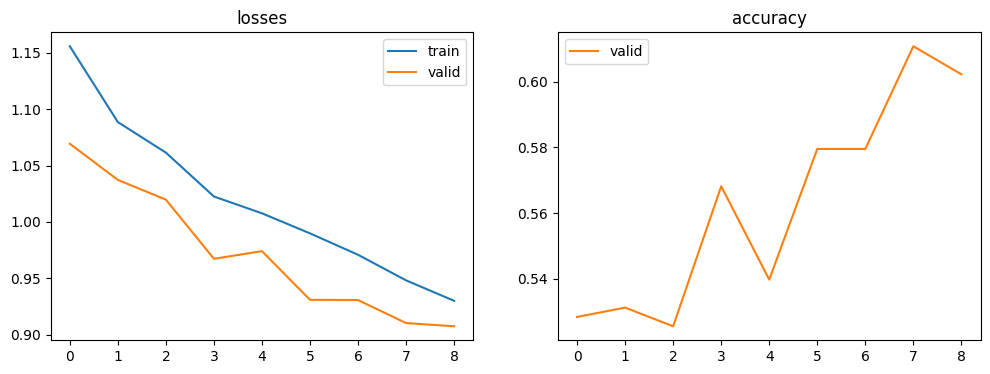

In [ ]:
learn_LeNet.recorder.plot_metrics()

Al igual que en la primera red que hemos entrenado, las gráficas muestran que la red ha ido aprendiendo razonablemente bien durante las distintas épocas. Normalmente, se puede esperar un rendimiento muy bueno cuando se utilizan redes preentrenadas en tareas similares, ya que el hecho de partir de unos pesos que ya han sido optimizados anteriormente suele facilitar el entrenamiento. Sin embargo, esta red no mejora en rendimiento a nuestra primera aporximación. Nuestra principal hipótesis es que, debido a que el dataset de entrenamiento de LeNet (MNIST, que contiene dígitos manuscritos) no se parece demasiado al nuestro (MosquitoAlert, que contiene imágnes de mosquitos en el medio), no nos estamos beneficiando demasiado de partir de un modelo preentrenado.

## AlexNet

Mismo procedimiento que con LeNet pero con la red AlexNet.

In [ ]:
from torchvision.models import alexnet

In [ ]:
class RedAlexNet(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super(RedAlexNet, self).__init__()
        self.alexnet = alexnet(pretrained=pretrained)
        # Reemplazar la última capa clasificadora para ajustar el número de clases
        self.alexnet.classifier[6] = nn.Linear(self.alexnet.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.alexnet(x)

In [ ]:
# Instanciar el modelo con pesos preentrenados
model = RedAlexNet(num_classes=4, pretrained=True)

# Handle class imbalance using the provided class weights
#class_weights = torch.FloatTensor([2.26, 31.07, 2.29, 11.10]).cuda()
class_weights = torch.FloatTensor([
    2.2643343051506317,  # Peso para 'Aedes_albopictus'
    31.066666666666666,  # Peso para 'Aedes_aegypti'
    2.293307086614173,   # Peso para 'Culex'
    11.095238095238095   # Peso para 'Japonicus+koreicus'
]).cuda()

loss_func = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
learn_AN = Learner(dls, model, loss_func=loss_func, metrics=accuracy)

# Mostrar un resumen del modelo
print(learn_AN.summary())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 158MB/s]


RedAlexNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 55 x 55   
Conv2d                                    23296      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 27 x 27   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 192 x 27 x 27  
Conv2d                                    307392     True      
ReLU                                                           
____________________________________________________________________________
                     64 x 192 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 384 x

In [ ]:
learn_AN.fine_tune(7)

epoch,train_loss,valid_loss,accuracy,time
0,0.663333,1.155777,0.434659,04:48


epoch,train_loss,valid_loss,accuracy,time
0,0.541717,1.212801,0.434659,04:46
1,0.524087,1.639001,0.434659,04:50


In [ ]:
learn_AN.recorder.plot_metrics()

El comportamiento de AlexNet nos ha sorprendido. Pensábamos que, al tratarse de una red entrenada con ImageNet, su rendimiento sería superior al de Lenet, pero no ha sido así y por el momento no encontramos justificación aparente.

(Nota: no podemos mostrar las curvas de aprendizaje ni el accuracy tras todas las épocas del entrenamiento porque nos quedamos sin acceso a las GPUs de google colab y ya no nos daba tiempo a repetir el experimento la segunda vez. En la primera ejecucion, AlexNet obtenía un 43% de accuracy final)

## VGGNet

Mismo procedimiento que con las anteriores pero con la red VGGNet.

In [ ]:
from torchvision.models import vgg16, VGG16_Weights

In [ ]:
def RedVGG16Pesos(num_classes, pretrained=True):
    # Cargar la arquitectura VGG16 preentrenada
    # Actualizado para usar el nuevo argumento 'weights'
    weights = VGG16_Weights.IMAGENET1K_V1 if pretrained else None
    model = vgg16(weights=weights)

    # Reemplazar la última capa clasificadora
    model.classifier[6] = nn.Linear(4096, num_classes)

    return model


In [ ]:
# Crear el modelo con 4 clases y pesos preentrenados
model = RedVGG16Pesos(num_classes=4)

loss_func = nn.CrossEntropyLoss(weight=class_weights)

learn_VGGPesos = Learner(dls, model, loss_func=loss_func, metrics=accuracy)

print(learn_VGGPesos.summary())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 110MB/s] 


VGG (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 224 x 224 
Conv2d                                    1792       True      
ReLU                                                           
Conv2d                                    36928      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 112 x 11 
Conv2d                                    73856      True      
ReLU                                                           
Conv2d                                    147584     True      
ReLU                                                           
__________________________________________

In [ ]:
learn_VGGPesos.fine_tune(9)

epoch,train_loss,valid_loss,accuracy,time
0,0.697106,1.274171,0.417614,04:51


epoch,train_loss,valid_loss,accuracy,time
0,0.526230,1.526273,0.434659,04:58
1,0.522368,1.321623,0.434659,04:55
2,0.525681,1.594915,0.434659,04:59
3,0.516802,1.539966,0.434659,05:42
4,0.513471,1.309633,0.434659,04:57
5,0.506189,1.340219,0.434659,04:56
6,0.505065,1.363100,0.434659,04:56
7,0.502340,1.320686,0.434659,04:55
8,0.494576,1.350334,0.434659,04:56


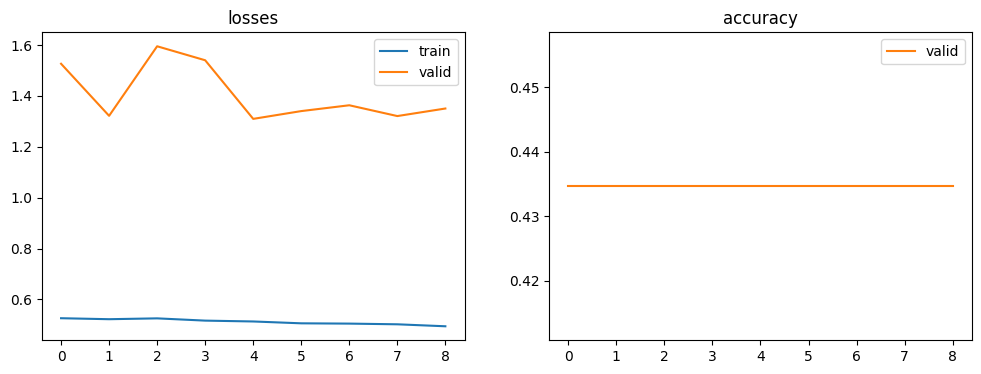

In [ ]:
learn_VGGPesos.recorder.plot_metrics()

Este modelo es el que más parámetros tiene de entre todos los que estamos probando. Este es el motivo por el que consideramos que el entrenamiento no ha ido tan bien como con otros modelos preentrenados, ya que al tener más pesos, es habitual que sean necesarios más ejemplos de entrenamiento y más épocas de entrenamiento para llevar a cabo el finetunning. Además, también consideramos como hipótesis que realizar transfer learning con modelos con muchos parámetros es más complicado que con modelos con menos parámetros, ya que se trata de modelos más complejos donde cada neurona realiza tareas mucho más concretas, lo que dificulta la posibilidad de que el transfer learning se realice con eficacia.

## ResNet

In [ ]:
# Cargar el modelo ResNet18
model = vision_learner(dls, resnet18, metrics=accuracy)

print(model.summary())

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Entrenar el modelo utilizando fine-tuning
model.fine_tune(9)

epoch,train_loss,valid_loss,accuracy,time
0,1.693961,0.853099,0.727273,05:37


epoch,train_loss,valid_loss,accuracy,time
0,1.019112,0.766616,0.764205,05:47
1,0.839001,0.727589,0.772727,05:49
2,0.696295,0.640962,0.784091,05:22
3,0.571610,0.637776,0.829545,04:44
4,0.460847,0.613424,0.821023,04:50
5,0.366693,0.639117,0.821023,04:50
6,0.296490,0.644184,0.818182,04:49
7,0.246856,0.628715,0.812500,04:58
8,0.213234,0.638915,0.806818,04:49


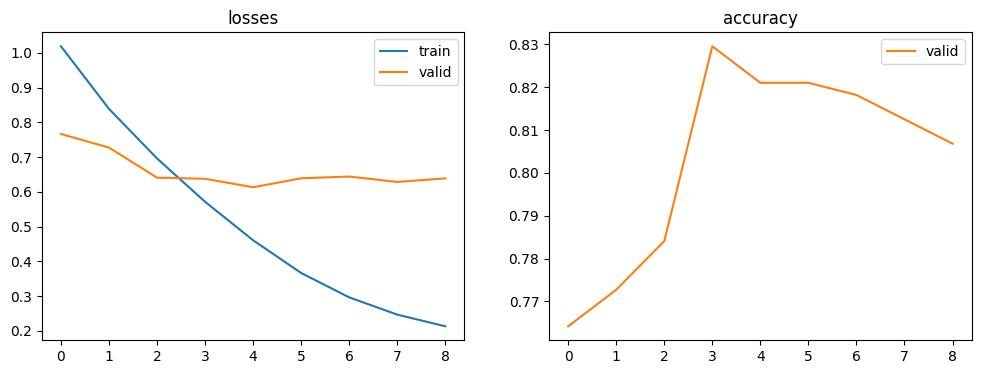

In [ ]:
model.recorder.plot_metrics()

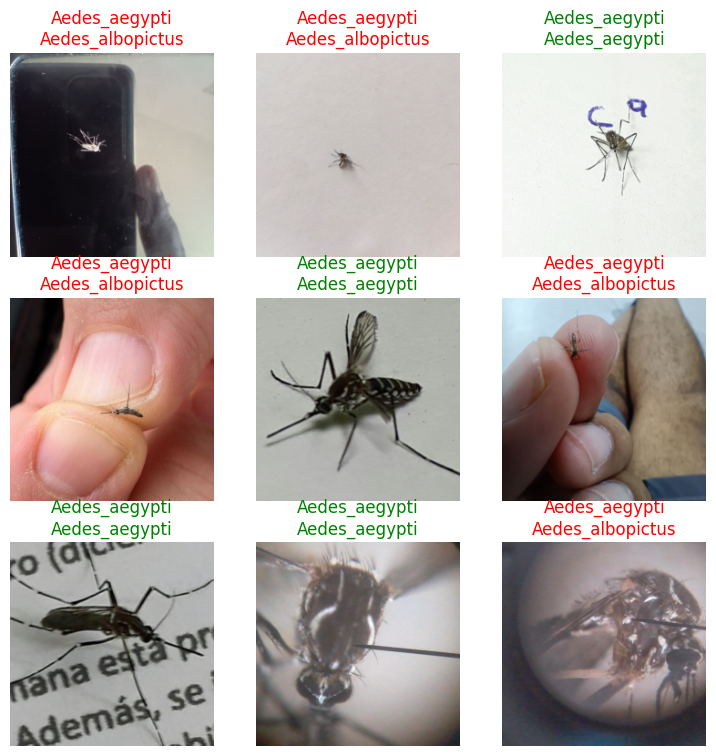

In [ ]:
model.show_results(dl=dls.valid, nrows=3, ncols=3)

ResNet es una red que se ha entrenado con el dataset ImageNet, el cual contiene una gran cantidad de imágenes de distintas y diversas clases. Además, al tener menos parámetros que VGG, por ejemplo, es más eficaz para la tarea de transfer learning. Atendiendo al rendimiento presentado por el modelo , podemos concluir que la tarea de transfer learning se ha llevado a cabo exitosamente y se ha proclamado como el modelo con mejor accuracy entre aquellos con los que hemos experimentado.

# ResNet con preprocesado

Debido a que ResNet ha sido el modelo con mejores resultados de los experimentos anteriores, vamos a probar a repetir la tarea de fine-tunning con el dataset de imágenes recortadas.

## Preparación del dataset de imágenes recortadas

In [ ]:
carpetas_interes = ['Japonicus+koreicus_segmentadas', 'Aedes_albopictus_segmentadas', 'Aedes_aegypti_segmentadas', 'Culex_segmentadas']
conteo_archivos = {}

# Ruta de la nueva carpeta para guardar las imágenes
ruta_nueva_carpeta = '/content/drive/MyDrive/VC_FINAL/Im_Segmentadas'
os.makedirs(ruta_nueva_carpeta, exist_ok=True)  # Crea la carpeta si no existe


# Lista solo las subcarpetas de interés
subcarpetas_interes = []

if os.path.exists(ruta_vc_final):
    print(f"Buscando subcarpetas con imgs recortadas dentro de: {ruta_vc_final} \n")
    subcarpetas = next(os.walk(ruta_vc_final))[1]  # Esto listará solo directorios
    for subcarpeta in subcarpetas:
        if subcarpeta in carpetas_interes:
            ruta_subcarpeta = os.path.join(ruta_vc_final, subcarpeta)
            archivos = os.listdir(ruta_subcarpeta)
            conteo_archivos[subcarpeta] = len(archivos)
            print(f"{subcarpeta}:  {len(archivos)} archivos")

            # Establece la ruta de destino para la subcarpeta
            destino_subcarpeta = os.path.join(ruta_nueva_carpeta, subcarpeta)

            # Verifica si la subcarpeta ya existe en el destino
            if not os.path.exists(destino_subcarpeta):
                # Copia la subcarpeta entera si no existe
                shutil.copytree(ruta_subcarpeta, destino_subcarpeta)
                print(f"Copiada subcarpeta: {subcarpeta}")
            else:
                # Si la subcarpeta ya existe, copia solo los archivos que faltan
                for archivo in archivos:
                    ruta_archivo_origen = os.path.join(ruta_subcarpeta, archivo)
                    ruta_archivo_destino = os.path.join(destino_subcarpeta, archivo)
                    if not os.path.exists(ruta_archivo_destino):
                        shutil.copy(ruta_archivo_origen, ruta_archivo_destino)
                print(f"Actualizada subcarpeta: {subcarpeta}")
else:
    print("La ruta no existe")

total_imagenes = sum(conteo_archivos.values())
print("\nTotal de imágenes en el dataset:", sum(conteo_archivos.values()))
print("Proceso de copia completado.")


Buscando subcarpetas con imgs recortadas dentro de: /content/drive/MyDrive/VC_FINAL/Files 

Culex_segmentadas:  768 archivos
Copiada subcarpeta: Culex_segmentadas
Aedes_albopictus_segmentadas:  730 archivos
Copiada subcarpeta: Aedes_albopictus_segmentadas
Aedes_aegypti_segmentadas:  52 archivos
Copiada subcarpeta: Aedes_aegypti_segmentadas
Japonicus+koreicus_segmentadas:  174 archivos
Copiada subcarpeta: Japonicus+koreicus_segmentadas

Total de imágenes en el dataset: 1724
Proceso de copia completado.


In [ ]:
verificar_y_limpiar_imagenes("/content/drive/MyDrive/VC_FINAL/Im_Segmentadas/")

In [ ]:
def stratified_splitter(items, train_size=0.85, random_state=42):
    # Obtener las etiquetas de los elementos
    labels = [parent_label(item) for item in items]

    # Dividir los datos de manera estratificada
    items_train, items_val = train_test_split(items, train_size=train_size, random_state=random_state, stratify=labels)

    # Crear listas de índices para entrenamiento y validación
    train_idx = [i for i, item in enumerate(items) if item in items_train]
    val_idx = [i for i, item in enumerate(items) if item in items_val]

    return (train_idx, val_idx)

# Definir el datablock
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=stratified_splitter, # RandomSplitter(valid_pct=0.15, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),  # Redimensionar todas las imágenes a 224x224
    batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]#data augmentation y normalización
)

# Cargar los datos en un DataLoader
dls = datablock.dataloaders("/content/drive/MyDrive/VC_FINAL/Im_Segmentadas/", bs=64)

# 85% entrenamiento, 15% test

test_dl = dls.valid

# Imprimir los conteos de nuevo
print("Número de elementos en el conjunto de entrenamiento:", len(dls.train.dataset))
print("Número de elementos en el conjunto de prueba:", len(test_dl.dataset))

Número de elementos en el conjunto de entrenamiento: 1465
Número de elementos en el conjunto de prueba: 259


In [ ]:
total_muestras = sum(conteo_archivos.values())
pesos_clases = {clase: total_muestras / conteo for clase, conteo in conteo_archivos.items() if clase in carpetas_interes}

print("Pesos de las clases: ", pesos_clases)

# Convertir los pesos en un tensor
weights_tensor = torch.tensor(list(pesos_clases.values()), dtype=torch.float)

Pesos de las clases:  {'Culex_segmentadas': 2.2447916666666665, 'Aedes_albopictus_segmentadas': 2.361643835616438, 'Aedes_aegypti_segmentadas': 33.15384615384615, 'Japonicus+koreicus_segmentadas': 9.908045977011493}


## Cargar y ejecutar ResNet

In [ ]:
# Cargar el modelo ResNet18
model = vision_learner(dls, resnet18, metrics=accuracy)

print(model.summary())

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Entrenar el modelo utilizando fine-tuning
model.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.707373,0.924871,0.687259,00:59


epoch,train_loss,valid_loss,accuracy,time
0,1.175061,0.805902,0.733591,00:59
1,0.975711,0.754171,0.741313,01:01
2,0.821383,0.707275,0.745174,01:00
3,0.696990,0.666767,0.783784,01:08
4,0.573700,0.738340,0.783784,01:00
5,0.494301,0.692918,0.799228,01:01
6,0.405196,0.665096,0.791506,01:02
7,0.341676,0.679572,0.791506,01:02
8,0.289485,0.692864,0.803089,01:00
9,0.254765,0.687798,0.806950,01:00


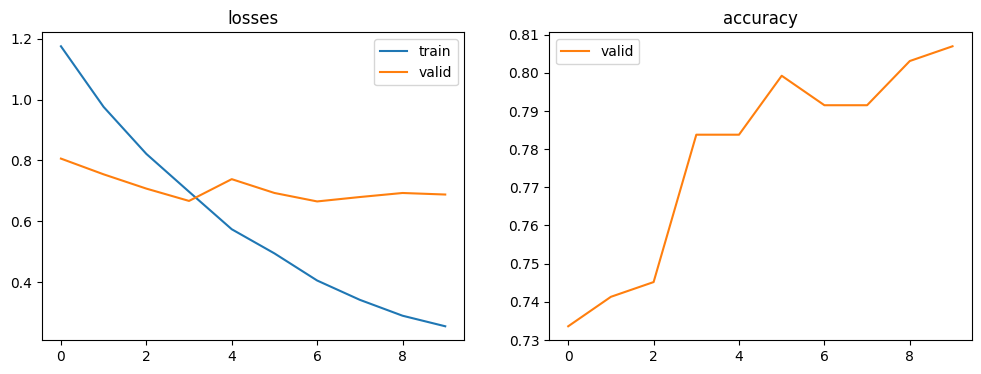

In [ ]:
model.recorder.plot_metrics()

En este caso, no hemos conseguido aumentar el rendimiento de la red con el nuevo dataset. Sin embargo, podemos extraer algunas hipótesis y conclusiones interesantes sobre este experimento:
1. El modelo sin recortar ofrece mejores resultados en un factor x1.03, pero el modelo recortado es más rápido en un factor de x2.6. Es decir, hemos conseguido reducir el tiempo de entrenamiento con una pérdida en el rendimiento bastante leve.
2. Este dataset recortado tiene imágenes más pequeñas (a priori, menos información) y, como se ha comentado en el apartado de recorte de las fotografías, el nº de ejemplos se ha reducido por algunos factores asociados con el procedimiento de detección. Con esta información en la mano, podemos afirmar que, si el rendimiento no ha bajado demasiado, el nuevo dataset ha conseguido paliar casi por completo la reducción de los ejemplos con una mejora en la calidad de los mismos.

Por tanto, consideramos que es una buena idea preprocesar las imágenes en contextos en los que los ejemplos contienen mucho ruido y concluimos que merecería la pena dedicar esfuerzos en elaborar un detector que sí esté especializado en detectar mosquitos para resolver este problema con más precisión que nuestras propuestas.

# Conclusiones sobre los modelos

Atendiendo a los resultados en accuracy de los modelos, concluimos que la mejor opción para resolver este problema mediante Deep Learning es ResNet sin preprocesado de imágenes. Sin embargo, vemos importante tener presente la ventana de oportunidad para la mejora que ofrece el preprocesado si se consigue dar con un detector de mosquitos especializado en esta tarea.

Mostramos en esta tabla un resumen con los resultados

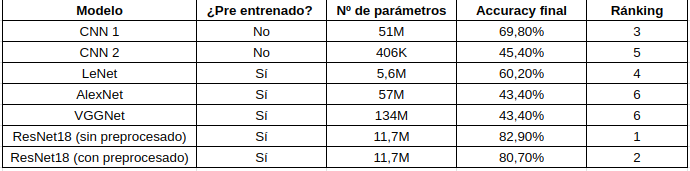